# Cleaning, part 1
This notebook cleans the data coming from notebook `01 Adding year to data`. It uses the functions in the script `post_scraping_text_processing.py`.

In [1]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import re
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

### Running functions from post_scraping_text_processing.py
`post_scraping_text_processing.py` contains some basic functions for processing this data, as well as some of the cleaning functions that will be generated in this notebook. As I worked through EDA in notebooks, I added functions to the script, so there will be some redundancy between the notebook and the script.

In [2]:
%run ../scripts/post_scraping_text_processing.py functions

Text processing functions loaded.


### Reading in the file from the previous notebook
Some columns, it turns out, are no longer necessary.

In [3]:
df = pd.read_csv("../assets/lyrics/master_data_20180626.csv", index_col=0)

In [4]:
df.columns

Index(['artist', 'title', 'album', 'text', 'english_score', 'release', 'name',
       'real_name'],
      dtype='object')

In [5]:
df.drop(['real_name', 'title', 'english_score'], axis = 1, inplace=True)

In [6]:
df.shape

(15691, 5)

***15,691 songs before cleaning. Some of these are in English, French, Kurdish, and other languages.***

## Cleaning rows with non-Turkish songs or characters

### Three immediate transformations:
- Some rows (40) represent instrumental tracks, and the text for these rows just says that there aren't any lyrics.
    - get rid of rows with 'Şarkı enstrümantal olduğu için şarkı sözü bulunmamaktadır' in 'text'.
- replace the weird × character with a real x
- get rid of songs with ANY non-Latin characters (there aren't many, but there are a few songs in Arabic or Russian)

In [7]:
df = df[~(df['text'].str.contains('Şarkı enstrümantal olduğu için şarkı sözü bulunmamaktadır'))]

In [8]:
df['text'] = df['text'].str.replace('×', 'x')

In [9]:
non_latin_chars = '[ΌΓΜΝΤΧάέήίαγδεζηθικλμνοπρςτυφχψωόБГДЗКМНОПСТЧЩабвгдежзийклмнопрстуфхцчшщъюяѕابتجحخدذرزسشصضطعفقكلمنهوي]'
df = df[~(df['text'].str.contains(non_latin_chars))]

### Harder choices:  other bad characters
- Most songs with characters like é aren't in Turkish, but some still are.
- Steps:
  - copy the corpus and explore it
  - pull out bad Latin characters (not punctuation)

In [10]:
corpus = df['text'].copy()

In [11]:
corpus.head()

285    Altın yüzüğüm kırıldı (hey) Suya düştü su duru...
286    Bir bağ bozumuydu gidişin Plajlar boşalmıştı B...
289    Bir of çeksem karşı ki dağlar yıkılır Bugün po...
292    Eğin dedikleri (anam) bir küçük şehir (nidem) ...
296    Subhanım Allah, sultanım Allah, Mağrifet eden ...
Name: text, dtype: object

In [12]:
corpus = corpus.map(remove_and_reg)
corpus = corpus.map(remove_punctuation)

In [13]:
corpus_letters = "".join(corpus)
"".join(set(corpus_letters))

'Ç̇lÂçUîê¸i]wä¶pğHMþx14′İS0QCÜ²qÃßbt\ufeffáLo5Ş®8ð3æV`¢ˊcPGEXdÓÛ}£sœ6ÉÑù Au*|ò–ÁT9YeKJì#fşZÚóčž{😂k&Wjöã“èª‚_g¡z”ïëü>a…Ö<[$IO‘FúyB%-û=Níâ�hnvàñôË2rÈšåR¿ýőĞ~D‐ıø’»¦7é+m'

In [14]:
corpus = corpus.map(lambda x: x.replace('�', ''))
corpus = corpus.map(lambda x: x.replace('😂', ''))
corpus = corpus.map(lambda x: x.replace('²', ''))

In [15]:
latin_bad_chars_regex = '[åïß£ðÉ¡äžÓ¢ÁčÑéñ¿ëúìàËÈ®òÃ¶šőãýþèóæáÚœÛíùøª]' # ḃ apparently meets b, � should be apostrophe, 😂 should be removed

In [16]:
latin_bad_chars_regex

'[åïß£ðÉ¡äžÓ¢ÁčÑéñ¿ëúìàËÈ®òÃ¶šőãýþèóæáÚœÛíùøª]'

***Some of these songs are in languages other than Turkish, but some are in Turkish. In these cases, the transcriber made non-standard choices for representing certain Turkish sounds.***

In [17]:
df[corpus.str.contains(latin_bad_chars_regex)].loc[10877,'text']

'Geceler yarim oldu Anam anam garibem Ağlamak kárim oldu Anam anam anam garibem Her dertten yıkılmazdım Anam anam garibem Sebebim zalim oldu Anam anam anam garibem Bayram gelmiş neyime Anam anam garibem Kan damlar yüreğime Anam anam anam garibem Yaralarım sızlıyor Anam anam garibem Doktor gelmiş neyime Anam anam anam garibem... '

In [18]:
df[corpus.str.contains(latin_bad_chars_regex)].head()

,artist,album,text,release,name
1000,Adx,Exécution,Fils d'Agrippine et de Germanicus Tu es devenu...,1998-01-01,Caligula
1007,Adx,Immortel,"Regardez-moi si vous l'osez, Je vous respire C...",2011-10-17,Immortel
1014,Adx,Exécution,On ne sait pas d'où il vient Ni comment il a f...,1998-01-01,L'étranger
1212,Agony,Millennium,Frente nacional unión Cero participación No ha...,1996-08-01,Guerrillas
2365,Alizee,taxedomask,Le monde est aux blondes décolorées J'annonce ...,2014-06-23,Blonde


### To get rid of the songs that have bad characters but exclude the Turkish ones:
- make a list of the indexes for Turkish-language lyrics that nevertheless contain bad Latin chars (Turkish exceptions)
- make a list of the index of the entries that have the bad Latin characters
- drop the Turkish exceptions from that list
- use that list to filter the original dataframe

In [19]:
df.loc[51041, 'text']

'Sabah uyandım, yanımda yoksun Solumda bir acı, senden yoksun Soluksuz kaldım köşelerde Yalnızım, sanki yorgun İnan, değildi sonsuz Bitti gitti seyrettik aşkı Sanmışım yolu yordamı bu Böyle yazılmadı ya da ben öyle kandım Şimdi, tek başımayken, Kimin öyküsü bu ? [Nakarat²] Bu benim öyküm, birazcık yaralı Kalbimin pek çok yeri yamalı Kan akar kanadımdan Düşer yere, yere kalanı Birazcık yaralı... Yeri yamalı... Akar kanadımdan.. Geri kalanı... Yamalı yamalı... '

In [20]:
tr_bad_chars = [53589, 53602, 7199, 10877, 14731, 51120, 53602, 54753, 19378, 20366, 21101, 22154, 22157, 27489, 28398, 38708, 49124]

In [21]:
non_turkish_index = corpus[corpus.str.contains(latin_bad_chars_regex)].index
non_turkish_index = corpus[non_turkish_index].drop(tr_bad_chars).index
df = df.drop(non_turkish_index)

In [22]:
df.shape

(15484, 5)

In [23]:
df.loc[453, 'text']

"Taleal bedru aleyna Min seniyyatil veda Vecebeş şükrü aleyna Veda alil lehida Ay doğdu üzerimize Veda tepelerinden Şükür gerekti bizlere Allah'a davetinden Eyyühel meb'u süfina Ci'te bil emril mut'a Ci'te şerreftel medina Merhaben ya hayra da "

## Combining this into a function, which can be found in the scripts subdirectory

In [24]:
df = pd.read_csv("../assets/lyrics/master_data_20180626.csv", index_col=0)

def grooming_language(df):
    """Takes a dataframe and performs 6 steps:
        - gets rid of unnecessary columns
        - gets rid of instrumental songs
        - replaces some dumb characters
        - gets rid on non-latin character songs
        - gets rid of Turkish non-latin character songs"""
    # Step 1: get rid of unnecessary columns, do initial corpus preparation
    df.drop(['real_name', 'title', 'english_score'], axis = 1, inplace=True)
    df.drop(28398, inplace = True)
    df['text'] = df['text'].map(remove_and_reg)
    df['text'] = df['text'].map(remove_punctuation)

    # Step 2: get rid of instrumental songs
    df = df[~(df['text'].str.contains('Şarkı enstrümantal olduğu için şarkı sözü bulunmamaktadır.'))]
    
    # Step 3: replace the weird x with regular x
    df['text'] = df['text'].str.replace('×', 'x')
    
    # Step 4: get rid of non-Latin songs
    non_latin_chars = '[ΌΓΜΝΤΧάέήίαγδεζηθικλμνοπρςτυφχψωόБГДЗКМНОПСТЧЩабвгдежзийклмнопрстуфхцчшщъюяѕابتجحخدذرزسشصضطعفقكلمنهوي]'
    df = df[~(df['text'].str.contains(non_latin_chars))]

    # Step 5: Replace some obvious non-issues
    df['text'] = df['text'].map(lambda x: x.replace('�', ''))
    df['text'] = df['text'].map(lambda x: x.replace('😂', ''))
    df['text'] = df['text'].map(lambda x: x.replace('²', ''))
    
    # Step 6: Take out the non-Turkish Latin-character songs
    latin_bad_chars_regex = '[åïß£ðÉ¡äžÓ¢ÁčÑéñ¿ëúìàËÈ®òÃ¶šőãýþèóæáÚœÛíùøª]'
    tr_bad_chars = [53589, 53602, 7199, 10877, 14731, 51120, 53602, 54753, 19378, 20366, 21101, 22154, 22157, 27489, 28398, 38708, 49124]
    non_turkish_index = corpus[corpus.str.contains(latin_bad_chars_regex)].index
    non_turkish_index = corpus[non_turkish_index].drop(tr_bad_chars).index
    df = df.drop(non_turkish_index)
    return df

In [25]:
df = grooming_language(df)

In [26]:
df.shape

(15523, 5)

### Now to check what's left

In [27]:
df[df['text'].str.contains('[åïß£ðÉ¡äžÓ¢ÁčÑéñ¿ëúìàËÈ®òÃ¶šőãýþèóæáÚœÛíùøª]')]

,artist,album,text,release,name
7199,Atilla Taş,Bir Atilla Taş Albümü,Bekarlar bekarlar Nasil yatarlar Anam yok Baba...,2007-05-04,Bekarlar
10877,Bülent Ersoy,Beddua,Geceler yarim oldu Anam anam garibem Ağlamak k...,1991-11-29,Geceler Yarim Oldu
14731,Cem Karaca,Yiyin Efendiler,Alamanya Çok uzaktan fetva ile bilinmez Alaman...,2017-06-09,Alamanya
19378,Edip Akbayram,Bir Şarkın Olsun Dudaklarında,Bu toprakta kalır adın Tohumların arasında Yeş...,1993-06-28,Ağıt
20366,Emrah,Sen Gülünce,BEN GURBETIN KUCAGINDA DÜSÉ KALKA YORULDUM BIR...,1991-08-06,İki Gözüm İki Çeşme
21101,Erkan Oğur,deli sevda,Siyah perçemlerin gonca yüzlerin Garip bülbül ...,2001-08-23,Siyah Perçemlerin Gonca Yüzlerin
22154,Fatih Yeşilgül,Ağlama,Bilmez misin ben bir tek sana yandım yine sana...,2018-01-24,Canına Kıyamadım
22157,Fatih Yeşilgül,Ağlama,Son noktasına kadar séN yazdırdın sonunda yaln...,2018-01-24,İnadına
27489,Hülya Avşar,Herşey Gönlünce Olsun,Kalplerimiz bir olsa Sevdamız başka başka Olsu...,1989-06-13,Kalplerimiz Bir Olsa
38708,Nihan,Terk-i Diyar,oturdugu yerden kaLkmas hicßirseyi umursamaz i...,2005-09-13,Kımılda


In [28]:
df = pd.read_csv("../assets/lyrics/master_data_20180626.csv", index_col=0)
df = grooming_language(df)

### Replacing non-standard characters
Some digging around suggests the following transformations. There are probably more, but there are diminishing returns for this kind of cleaning.

In [29]:
def replace_weird_chars(text_col):
    text_col = text_col.str.replace('ä', 'a')
    text_col = text_col.str.replace('á', 'a')
    text_col = text_col.str.replace('ß', 'b')
    text_col = text_col.str.replace('Ã¢', 'a')
    text_col = text_col.str.replace('É', 'E')
    text_col = text_col.str.replace('Ã‚', 'A')
    text_col = text_col.str.replace('é', 'e')
    text_col = text_col.str.replace('ð', 'ğ')
    text_col = text_col.str.replace('w', 'v')
    text_col = text_col.str.replace('göanül', 'gönül')
    text_col = text_col.str.replace('ú', 'u')
    text_col = text_col.str.replace('ý', 'ı')
    text_col = text_col.str.replace('í', 'i')
    text_col = text_col.str.replace('Söz  Fikret Şeneş & Müzik  Diques Fleche', '')
    text_col = text_col.str.replace('Icqum 150' , '')
    text_col = text_col.str.replace('Montesquieuyu' , '')
    return text_col

def drop_more_wrong_language(df):
    df.drop(df[df['text'].str.contains('qu')].index, inplace = True)
    df.drop(df[(df['text'].str.contains('of') & df['text'].str.contains('my')) | (df['text'].str.contains('the') & df['text'].str.contains('you'))].index, inplace = True)
    df.drop(df[(df['text'].str.contains('your'))].index, inplace = True)
    df.drop(df[(df['text'].str.contains(' for '))].index, inplace = True)
    df.drop(df[(df['text'].str.contains(' For '))].index, inplace = True)
    df.drop(df[(df['text'].str.contains(' With '))].index, inplace = True)
    df.drop(df[(df['text'].str.contains(' love '))].index, inplace = True)
    df.drop(df[(df['text'].str.contains('Love'))].index, inplace = True)
    df.drop(df[(df['text'].str.contains(' çi '))].index, inplace = True)
    df = df[df['artist'] != 'Agire Jiyan'] # These artists only write in Kurdish
    df = df[df['artist'] != 'Abidin Biter']
    return df

def clean_bad_langauge(df):
    """Wrapper for grooming_langauge, replace_weird_chars, and drop_more_wrong_language"""
    df = grooming_language(df)
    df['text'] = replace_weird_chars(df['text'])
    df = drop_more_wrong_language(df)
    return df

### Testing... does this all work together?

In [30]:
df.shape

(15523, 5)

### The final script includes a few more cleaning functions that further reduce the total data to 15,425

In [31]:
%run ../scripts/post_scraping_text_processing.py run

/Users/jswithers/ga-dsi/capstone/scripts/post_scraping_text_processing.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['text'] = df['text'].map(lambda x: x.replace('×', 'x'))


df loaded.
15385 rows x 5 columns


## Zipf's Law
From [Wikipedia](https://en.wikipedia.org/wiki/Zipf%27s_law):  
>Zipf's law states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table.  

This allows for a visual and high-level confirmation that our data comes from a corpus of natural language utterances.

### Making a list of word frequencies with `CountVectorizer`

In [32]:
cvec = CountVectorizer()
cvec.fit(corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [33]:
transformed_corpus = cvec.transform(corpus)

word_table = pd.DataFrame(transformed_corpus.toarray(), columns=cvec.get_feature_names())

word_series = word_table.sum()

word_series = word_series.sort_values(ascending = False)

zipfs_test_df = pd.DataFrame({
    'word': word_series.index,
    'count': word_series.values
})

### Generating the plot

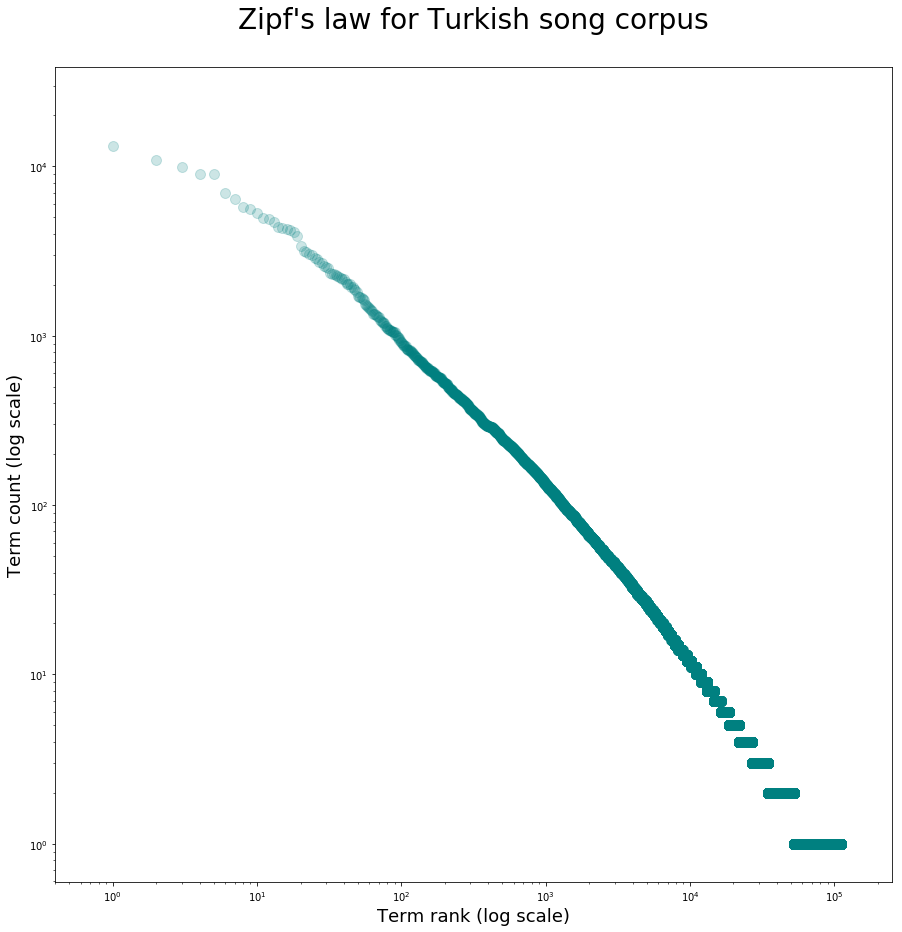

In [34]:
plt.figure(figsize=(15,15))
plt.yscale('log')
plt.xscale('log')
plt.scatter(zipfs_test_df.index, zipfs_test_df['count'], s = 100, marker = 'o', alpha = 0.2, c = "teal")
plt.xlim((10**-.4,10**5.4))
plt.xlabel("Term rank (log scale)", fontsize = 18)
plt.ylabel("Term count (log scale)", fontsize = 18)
plt.title("Zipf's law for Turkish song corpus\n", fontsize = 28)

plt.savefig("../assets/visualizations/zipf.png")